**Author**: Karlos Lao

**Last Revision Date**: Nov 15, 2023

**Description**: This project aims to build a model that predicts country GDP per capita values as either "High" or "Low", using a selection of predictor variables in the "world" dataset.

**Data Source**: World95: U.N. Demographic Data, 1995.

In [5]:
# If not install, use install.packages("sf")
library(tidyverse)
suppressWarnings(library(tidyverse))
library(dplyr)
# for reading shapefiles
library(sf)
# for ML algorithms
library(caret)
library(likert)
library(grid)
library(gridExtra)

library(ggpubr)
# for logistic regression
library(glmnet)
# for correlation matrix
library(ggcorrplot)


**Data Preparation**

In [3]:
# Get current working directory
print(getwd())

[1] "c:/Users/kailo/Desktop/R_Predict_CountryGDP_ML"


In [7]:
# Load Data from a shapefile
data <- st_read("world.shp")

# Generate a new variable named 'GDP_High_low'
# This variable categorizes countries based on the 'GDP_CAP' values. 
# Countries with 'GDP_CAP' values >= the median are labeled as 'High', 
# and those < median are labeled as 'Low'. 
# This variable will serve as the target variable."

data <- data %>%
  mutate(GDP_High_Low = ifelse(GDP_CAP >= median(GDP_CAP), "High", "Low"))

# Drop the 'geometry' column because we don't need it
data <- st_drop_geometry(data)
# Quickly inspect the data types
str(data)

Reading layer `world' from data source 
  `C:\Users\kailo\Desktop\R_Predict_CountryGDP_ML\world.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 108 features and 26 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -15679260 ymin: -6224955 xmax: 15351770 ymax: 9252194
Projected CRS: World_Winkel_II
'data.frame':	108 obs. of  27 variables:
 $ ISO_3DIGIT  : chr  "AFG" "AZE" "ARM" "ARG" ...
 $ CNTRY_NAME  : chr  "Afghanistan" "Azerbaijan" "Armenia" "Argentina" ...
 $ POP_CNTRY   : num  17250390 5487866 3377228 33796870 17827520 ...
 $ SQKM_CNTRY  : num  641869 85808 29872 2781013 7706142 ...
 $ LANDLOCKED  : chr  "Y" "Y" "Y" "N" ...
 $ RELIGION    : chr  "Muslim" "Muslim" "Orthodox" "Catholic" ...
 $ REGION      : num  3 5 5 6 1 1 5 6 4 1 ...
 $ CLIMATE     : int  3 3 0 8 3 8 3 5 4 8 ...
 $ POPULATN    : int  20500 7400 3700 33900 17800 8000 600 256 1359 10100 ...
 $ URBAN       : int  18 54 68 86 85 58 83 45 25 96 ...
 $ LIFEEXPF    : int  44 7

In [8]:
# There's no DENSITY variable in the dataset
# We need to create the pop.density variable (population per sqkm)
data$DENSITY <- data$POP_CNTRY / data$SQKM_CNTRY

# subset the dataset with the selected predictor variables
data_sub <- data %>% 
  select("DENSITY", "URBAN", "LIFEEXPF", "LIFEEXPM", "LITERACY", "BIRTH_RT",
         "DEATH_RT", "FERTILTY", "POP_INCR", "BABYMORT", "GDP_High_Low")


# drop observations/ remove countries with missing data (0 = NoData in this case)
data_filtered <- data_sub %>%
  drop_na() %>%
  filter(`DENSITY` != 0, `URBAN`!=0, `LIFEEXPF`!=0, `LIFEEXPM`!=0, `LITERACY`!=0, 
         `BIRTH_RT`!=0, `DEATH_RT`!=0, `FERTILTY`!=0, `POP_INCR`!=0, `BABYMORT`!=0,)

**Data Transformation**

In [9]:
# Normalize the data with an z-score transformation


data_z <- data_filtered %>%
  # columns to be scaled are 1:10, 
  mutate(across(.cols = 1:10, ~ as.vector(scale(.)), .names = "scaled_{.col}")) %>%
  select(c(11,12:21))

# convert "GDP_High_Low from string to factor type
data_z$GDP_High_Low <- as.factor(data_z$GDP_High_Low)

# check the result
str(data_z)

'data.frame':	103 obs. of  11 variables:
 $ GDP_High_Low   : Factor w/ 2 levels "High","Low": 2 1 1 1 1 1 1 1 2 1 ...
 $ scaled_DENSITY : num  -0.2541 -0.1854 -0.0944 -0.2814 -0.2996 ...
 $ scaled_URBAN   : num  -1.611 -0.104 0.481 1.234 1.193 ...
 $ scaled_LIFEEXPF: num  -2.403 0.488 0.488 0.488 0.954 ...
 $ scaled_LIFEEXPM: num  -2.084 0.262 0.369 0.369 1.008 ...
 $ scaled_LITERACY: num  -2.11 0.861 0.861 0.732 0.947 ...
 $ scaled_BIRTH_RT: num  2.154 -0.27 -0.27 -0.512 -0.916 ...
 $ scaled_DEATH_RT: num  2.874 -0.625 -0.858 -0.159 -0.392 ...
 $ scaled_FERTILTY: num  1.752 -0.418 -0.207 -0.418 -0.895 ...
 $ scaled_POP_INCR: num  0.909 -0.272 -0.272 -0.356 -0.272 ...
 $ scaled_BABYMORT: num  3.227 -0.234 -0.443 -0.479 -0.955 ...


**Check Data Distribution After Transformation**

In [10]:
# Get actual counts of "high" and "low" in the observations
tapply(data_z$GDP_High_Low, data_z$GDP_High_Low, length)
# There are 3 extra counts of "Low", we'll need to balance the class

# Evenly balance the two classes to 50 observations each
df1 <- data_z %>% 
  filter(GDP_High_Low == "High") %>% 
  sample_n(50)

df2 <- data_z %>% 
  filter(GDP_High_Low == "Low") %>% 
  sample_n(50)

df <- bind_rows(df1, df2, .id = NULL)

# Double check the result to make sure they are balanced
tapply(df$GDP_High_Low, df$GDP_High_Low, length)

# Lastly, rename the variables to finalize prepping
names(df) <- c("GDP_High_Low", "DENSITY", "URBAN", 
                   "LIFEEXPF", "LIFEEXPM", "LITERACY", "BIRTH_RT", 
                   "DEATH_RT", "FERTILTY", "POP_INCR", "BABYMORT")

High  Low 
  50   53

High  Low 
  50   50

**Model Training Preparation**

In [12]:
# create training and validation data
Training <- createDataPartition(df$GDP_High_Low, p=0.75, list=FALSE)
training <- df[Training,]
validation <- df[-Training,]

In [13]:
# Set Up Modelling Parameters
# Do a 10-fold cross validation to avoid data overfitting, 
# and repeat 10 times to reduce randomness in the results.
control <- trainControl(method="repeatedcv", number=10, repeats=10)
metric <- "Accuracy"

*Linear Discriminant Analysis (lda)*

In [15]:
set.seed(123)
fit.lda <- train(GDP_High_Low~., data=training, method="lda", metric=metric, trControl=control)
predictions <- predict(fit.lda, validation)

cm <- confusionMatrix(predictions, as.factor(validation$GDP_High_Low))

*Classification and Regression Trees (cart)*

In [17]:
fit.cart <- train(GDP_High_Low~., data=training, method="rpart", metric=metric, trControl=control)
predictions <- predict(fit.cart, validation)

cm1 <- confusionMatrix(predictions, as.factor(validation$GDP_High_Low))

*k-Nearest Neighbors (knn)*

In [18]:
fit.knn <- train(GDP_High_Low~., data=training, method="knn", metric=metric, trControl=control)
predictions <- predict(fit.knn, validation)

cm2 <- confusionMatrix(predictions, as.factor(validation$GDP_High_Low))

*Support Vector Machine (svm)*

In [27]:
#install.packages("kernlab")
fit.svm <- train(GDP_High_Low~., data=training, method="svmRadial", metric=metric, trControl=control)
predictions <- predict(fit.svm, validation)

cm3 <- confusionMatrix(predictions, as.factor(validation$GDP_High_Low))

*Logistic Regression (glm)*

In [28]:
#install.packages("glmnet")
fit.glm <- train(GDP_High_Low~., data=training, method = "glmnet", metric=metric,trControl=control)
predictions <- predict(fit.glm, validation)

cm4 <- confusionMatrix(predictions,
                       as.factor(validation$GDP_High_Low))

**Model Evaluation**

In [29]:
# summary of results
results <- resamples(list(lda=fit.lda, cart=fit.cart, knn=fit.knn, svm=fit.svm, glm=fit.glm))
summary(results)


Call:
summary.resamples(object = results)

Models: lda, cart, knn, svm, glm 
Number of resamples: 100 

Accuracy 
      Min.   1st Qu.    Median      Mean 3rd Qu. Max. NA's
lda  0.375 0.7142857 0.8571429 0.8092857 0.87500    1    0
cart 0.375 0.7500000 0.8571429 0.8330357 1.00000    1    0
knn  0.375 0.7500000 0.8750000 0.8444643 0.90625    1    0
svm  0.500 0.7500000 0.8571429 0.8298214 0.87500    1    0
glm  0.500 0.7500000 0.8660714 0.8465476 1.00000    1    0

Kappa 
           Min.   1st Qu. Median      Mean 3rd Qu. Max. NA's
lda  -0.2727273 0.4615385  0.720 0.6154922  0.7500    1    0
cart -0.2500000 0.5000000  0.720 0.6641144  1.0000    1    0
knn  -0.2500000 0.5000000  0.750 0.6878761  0.8125    1    0
svm   0.0000000 0.5000000  0.720 0.6570312  0.7500    1    0
glm   0.0000000 0.5000000  0.735 0.6936880  1.0000    1    0


In [30]:
# Looking solely at classification accuracy, it appears that "glm" perform the 
# best (highest mean accuracy: 0.85 and mean kappa value: 0.69).

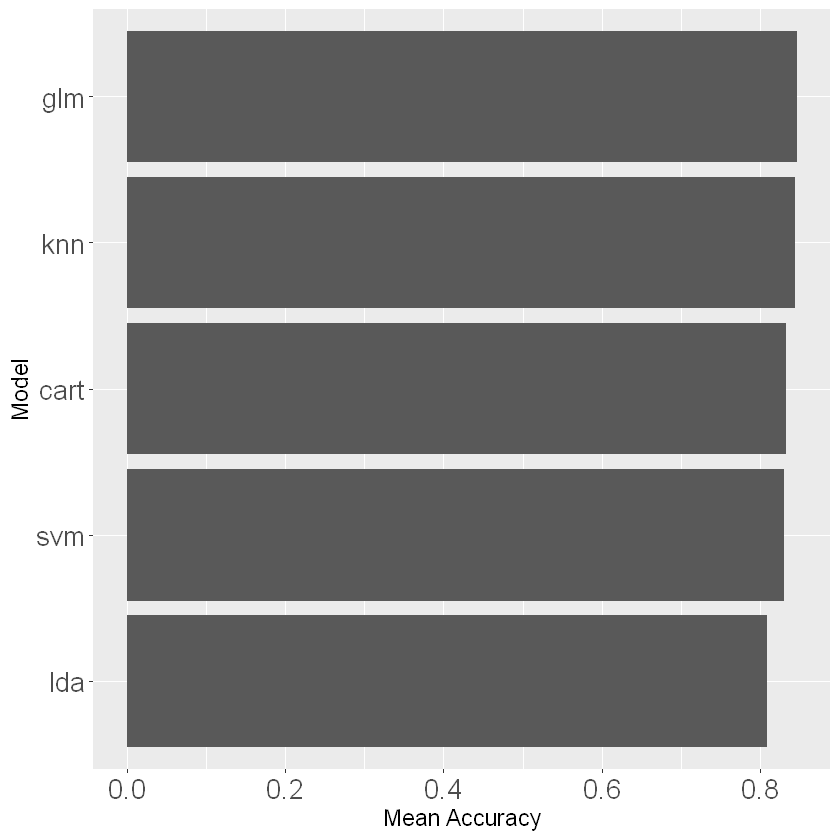

In [31]:
# Plot model accuracies
results_df <- as.data.frame(results)

results_tidy <- results_df %>% 
  pivot_longer(names_to = "Model", values_to = "Accuracy", -Resample) %>% 
  group_by(Model) %>% 
  summarise(Mean_Accuracy = mean(Accuracy))

mean_acc <- results_tidy %>% 
  ggplot(aes(x=fct_reorder(Model, Mean_Accuracy), y=Mean_Accuracy))+
  geom_bar(stat = "identity")+
  coord_flip()+
  xlab("Model")+
  ylab("Mean Accuracy")+
  theme(text = element_text(size = 20),
        title = element_text(size = 14))

mean_acc

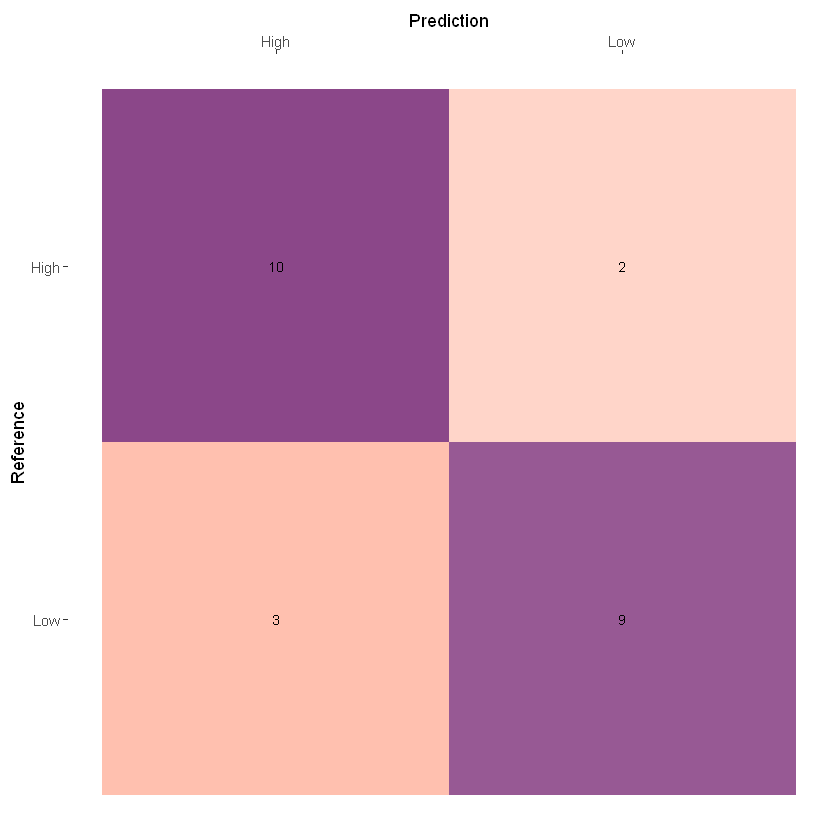

In [32]:
# Create a Confusion Matrix for the Best Model ('glm')
# 'cm4' is the confusion matrix for 'glm'
cm_4d <- as.data.frame(cm4$table)
cm_4d$diag <- cm_4d$Prediction == cm_4d$Reference # Get the Diagonal
cm_4d$ndiag <- cm_4d$Prediction != cm_4d$Reference # Off Diagonal     
cm_4d[cm_4d == 0] <- NA # Replace 0 with NA for white tiles
cm_4d$Reference <-  reverse.levels(cm_4d$Reference) # diagonal starts at top left
cm_4d$ref_freq <- cm_4d$Freq * ifelse(is.na(cm_4d$diag),-1,1)

best_m <-  ggplot(data = cm_4d, aes(x = Prediction , y =  Reference, fill = Freq))+
  scale_x_discrete(position = "top") +
  geom_tile( data = cm_4d,aes(fill = ref_freq)) +
  scale_fill_gradient2(guide = FALSE ,low="red3",high="orchid4", midpoint = 0,na.value = 'white') +
  geom_text(aes(label = Freq), color = 'black', size = 3)+
  theme_bw() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.position = "none",
        panel.border = element_blank(),
        plot.background = element_blank(),
        axis.line = element_blank(),
  )
best_m

In [34]:
# Determine Variable Importance ('varImp')

importance1 <- varImp(fit.lda)
importance2 <- varImp(fit.cart)
importance3 <- varImp(fit.knn)
importance4 <- varImp(fit.svm)
importance5 <- varImp(fit.glm)

# Check structure of the data.frames
#str(importance1)

# Extract importance into a df
imp1 <- importance1$importance 
imp2 <- importance2$importance
imp3 <- importance3$importance
imp4 <- importance4$importance
imp5 <- importance5$importance

In [35]:
# Plot the Variable Importance by Model
# Linear Discriminant Analysis (lda)
p1 <- imp1 %>% 
  mutate(Predictor = rownames(imp1)) %>% 
  pivot_longer(names_to = "GDP_Per_Capita", values_to = "Importance", -Predictor) %>%
  ggplot(aes(x=Predictor, y=Importance))+
  geom_segment(aes(x=Predictor, xend=Predictor, y=0, yend=Importance), color="skyblue") +
  geom_point(color="blue", size=4, alpha=0.6) +
  theme_light() +
  coord_flip() +
  theme(
    panel.grid.major.y = element_blank(),
    panel.border = element_blank(),
    axis.ticks.y = element_blank())+
  ylab("Linear Discriminant Analysis")+
  xlab("")

# Classification and Regression Trees (cart)
p2 <- imp2 %>% 
  mutate(Predictor = rownames(imp2)) %>% 
  pivot_longer(names_to = "GDP_Per_Capita", values_to = "Importance", -Predictor) %>%
  ggplot(aes(x=Predictor, y=Importance))+
  geom_segment(aes(x=Predictor, xend=Predictor, y=0, yend=Importance), color="skyblue") +
  geom_point(color="blue", size=4, alpha=0.6) +
  theme_light() +
  coord_flip() +
  theme(
    panel.grid.major.y = element_blank(),
    panel.border = element_blank(),
    axis.ticks.y = element_blank())+
  ylab("Classification & Regression Tree")+
  xlab("")

# k-Nearest Neighbors (knn)
p3 <- imp3 %>% 
  mutate(Predictor = rownames(imp3)) %>% 
  pivot_longer(names_to = "GDP_Per_Capita", values_to = "Importance", -Predictor) %>%
  ggplot(aes(x=Predictor, y=Importance))+
  geom_segment(aes(x=Predictor, xend=Predictor, y=0, yend=Importance), color="skyblue") +
  geom_point(color="blue", size=4, alpha=0.6) +
  theme_light() +
  coord_flip() +
  theme(
    panel.grid.major.y = element_blank(),
    panel.border = element_blank(),
    axis.ticks.y = element_blank())+
  ylab("k-Nearest Neighbors")

# Support Vector Machine (svm)
p4 <- imp4 %>% 
  mutate(Predictor = rownames(imp4)) %>% 
  pivot_longer(names_to = "GDP_Per_Capita", values_to = "Importance", -Predictor) %>%
  ggplot(aes(x=Predictor, y=Importance))+
  geom_segment(aes(x=Predictor, xend=Predictor, y=0, yend=Importance), color="skyblue") +
  geom_point(color="blue", size=4, alpha=0.6) +
  theme_light() +
  coord_flip() +
  theme(
    panel.grid.major.y = element_blank(),
    panel.border = element_blank(),
    axis.ticks.y = element_blank())+
  ylab("Support Vector Machine")+
  xlab("")

# Logistic Regression (glm)
p5 <- imp5 %>% 
  mutate(Predictor = rownames(imp5)) %>% 
  pivot_longer(names_to = "GDP_Per_Capita", values_to = "Importance", -Predictor) %>%
  ggplot(aes(x=Predictor, y=Importance))+
  geom_segment(aes(x=Predictor, xend=Predictor, y=0, yend=Importance), color="skyblue") +
  geom_point(color="blue", size=4, alpha=0.6) +
  theme_light() +
  coord_flip() +
  theme(
    panel.grid.major.y = element_blank(),
    panel.border = element_blank(),
    axis.ticks.y = element_blank())+
  ylab("Logistic Regression")+
  xlab("")

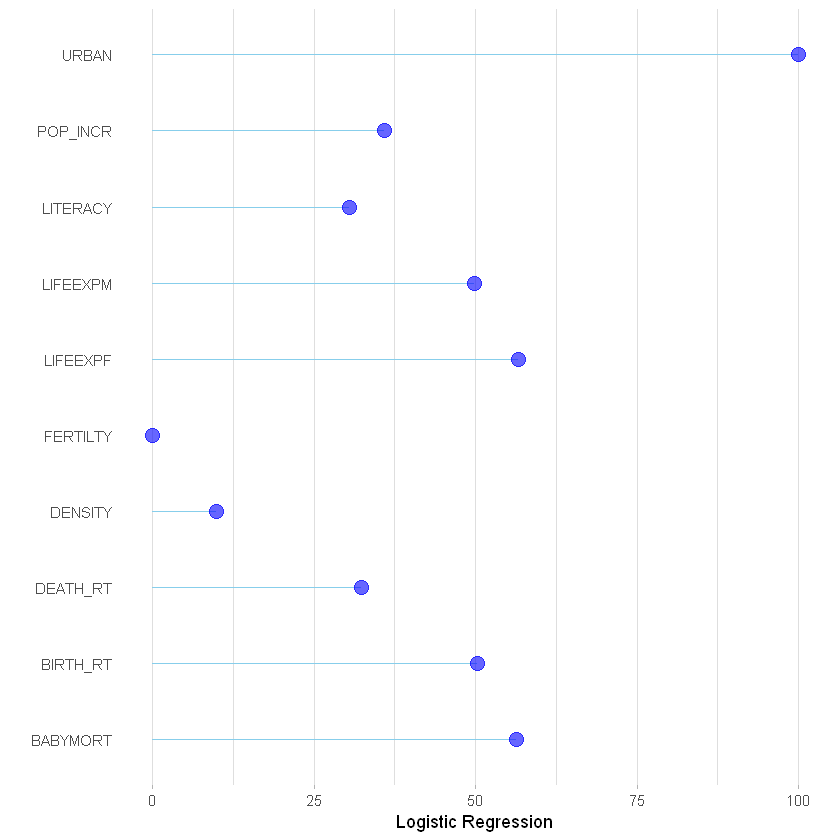

In [37]:
# Plot the Variable Importance from "glm (our best model)"
p5

In [44]:
# Plot them all on a single lollipop-chart
plot_importance <- ggarrange(p1, p2, p3, p4, p5, ncol = 1, heights = c(4, 4, 4, 4, 4), width = 6) +
  theme(text = element_text(size = 12)) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  theme(plot.margin = margin(2, 2, 2, 2))

# save the plot to a file
ggsave("plot_importance.png", plot_importance, height = 10, width = 8)

# open the saved image in a viewer
png_file <- "plot_importance.png"
browseURL(png_file)

Warning message in as_grob.default(plot):
"Cannot convert object of class numeric into a grob."


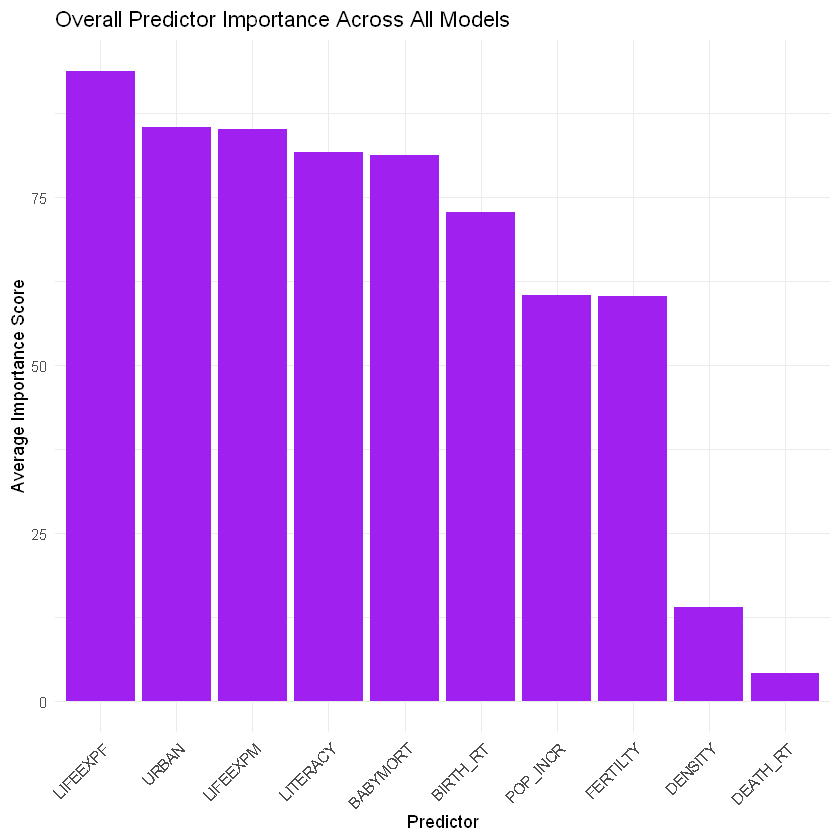

In [45]:
# Get the avg. variable importance for each predictor across all models

average_importance <- rowMeans(cbind(imp1, imp2, imp3, imp4, imp5))

# Create a data frame for plotting
importance_df <- data.frame(Predictor = names(average_importance), Importance = average_importance)

# Sort the data frame by importance score in descending order
importance_df <- importance_df[order(importance_df$Importance, decreasing = TRUE), ]

# Create the plot
library(ggplot2)
ggplot(importance_df, aes(x = reorder(Predictor, -Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "purple") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x = "Predictor", y = "Average Importance Score") +
  ggtitle("Overall Predictor Importance Across All Models")

**Last Check for Collinearity with a Correlation Matrix**

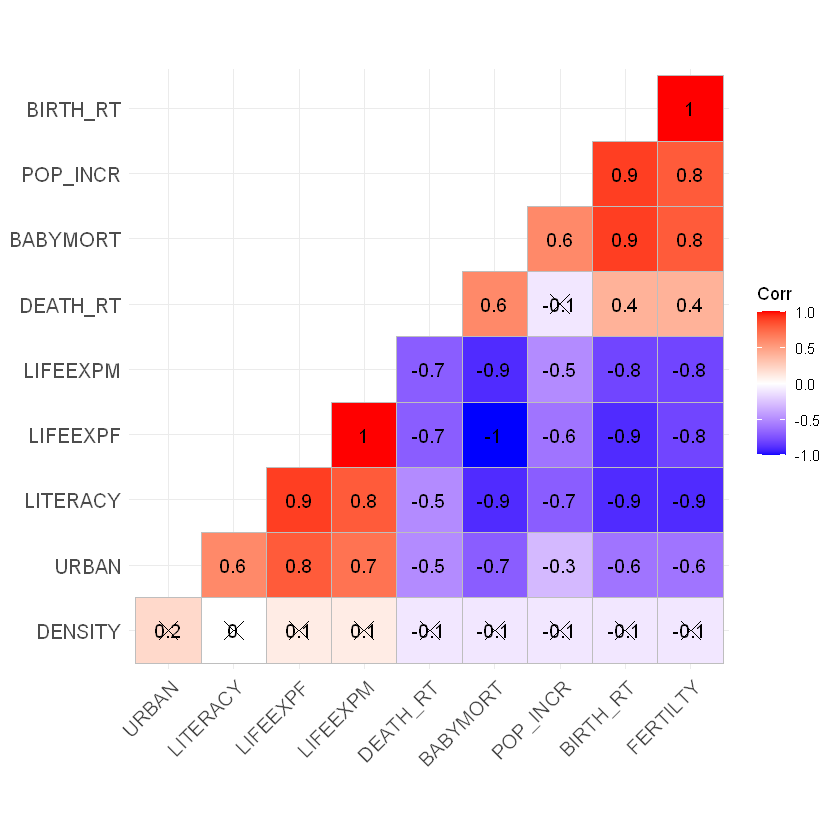

In [49]:
# source: http://www.sthda.com/english/wiki/ggcorrplot-visualization-of-a-correlation-matrix-using-ggplot2

test_df <- df %>% 
  select("DENSITY", "URBAN", "LIFEEXPF", "LIFEEXPM", "LITERACY", "BIRTH_RT",
         "DEATH_RT", "FERTILTY", "POP_INCR", "BABYMORT")

# compute a matrix of correlation p-values
p.mat <- cor_pmat(test_df)

# compute a correlation matrix
corr <- round(cor(test_df),1)

# Argument p.mat indicates the no significant correlation coefficient
# Visualize the Correlation Matrix
ggcorrplot(corr, hc.order = TRUE, type = "lower",lab = TRUE, p.mat= p.mat)

**Interpretation/Observations**

The four most important predictors are:
    
    "LIFEEXPF: average female life expectancy"
    "URBAN: percent of people living in cities"
    "LIFEEXPM: average male life expectancy"
    "LITERACY: percent of people who can read"

The least effective predictors are:
    
    "DEATH_RT: number of deaths per 100 people"
    "DENSITY: population density"
    
The data quality of these two variables may be subpar, and their data distribution could be heavily skewed. Removing them might improve our models, but finding suitable substitutes is challenging because many other variables also have numerous rows with missing data (value = 0). Therefore, replacing these two predictors could necessitate removing additional observations (i.e. countries). Consequently, this would decrease the sample size once more, potentially leading to inflated model results due to training with a smaller dataset.

If there are more variables and more consistent data, drawing conclusion from the correlation matrix shown.  I would pay extra attention when analyzing pairs such as:

    "BIRTH_RT" and "FERTILITY"
    "POP_INCR" and "BIRTH_RT"
    "LIFEEXPF" and "LIFEEXPM" 

because they exhibit strong positive correlations with each other.